In [4]:
# Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

In [5]:
# 1. Identify Feature Types
def get_feature_types(df, target_col='Attack Type'):
    """Identify numeric and categorical features."""
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)
    return numeric_features, categorical_features

In [6]:
# 2. Outlier Calculation
def calculate_outliers_percentage(df):
    """Calculate the percentage of outliers for each feature using IQR."""
    outlier_percentages = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            outlier_percentage = len(outliers) / len(df) * 100
            outlier_percentages[column] = outlier_percentage
    return outlier_percentages

In [7]:
# 3. Correlation analysis (Sesuai request Anda)
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Analyze correlations between numerical features.
    """
    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap (Akan muncul window baru di VS Code)
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [8]:
# 4. Variance analysis - Levene (Sesuai request Anda)
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    """  
    Analyze the homogeneity of variances using Levene's test.  
    """  
    results_levene = {}  
    
    for feature in numeric_features:  
        # Group data by y and filter out groups with zero values  
        if target_col not in df.columns:
            continue
            
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                  if not group[feature].dropna().empty]  
        
        # Filter out groups that contain only zero values or have zero variance  
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Check if there are at least two groups with valid data  
        if len(groups) < 2:  
            # print(f"Not enough valid groups to perform Levene's test for feature: {feature}")  
            continue  # Skip this feature if not enough valid groups  

        # Perform Levene's Test  
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

print("Helper functions ready.")

Helper functions ready.


In [9]:
# 5. Feature importance analysis (Kruskal-Wallis) - Sesuai request Anda
def analyze_feature_importance_kruskal(df, numeric_features, target_col='Attack Type'):
    """Analyze feature importance using the Kruskal-Wallis test."""
    h_scores = {}
    
    for feature in numeric_features:
        # Cek jika kolom ada di dataframe
        if feature not in df.columns or target_col not in df.columns:
            continue
            
        # Group data by y and perform the Kruskal-Wallis test
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col) if len(group) > 0]
        
        # Kruskal-Wallis butuh minimal 2 grup
        if len(groups) < 2:
            continue
            
        h_stat, p_val = stats.kruskal(*groups)
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}

    # Create a DataFrame from the results
    if not h_scores:
        return pd.DataFrame() # Return empty df if fails

    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)

    # Plotting H-statistics
    plt.figure(figsize=(18, 10))
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')
    plt.xlabel('Features')
    plt.ylabel('H-statistic')
    plt.tight_layout()
    plt.show()

    return h_scores_df

In [10]:
# 6. Feature importance analysis (MODIFIKASI: Tree Model - LightGBM)
# Fungsi ini menggantikan analyze_feature_importance_rf agar sesuai keinginan Anda pakai LightGBM
def analyze_feature_importance_lgbm(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a LightGBM classifier (Gain).
    Modifikasi dari Random Forest agar sesuai request LightGBM.
    """
    # Import di dalam fungsi jaga-jaga
    import lightgbm as lgb
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import confusion_matrix, classification_report
    from sklearn.preprocessing import LabelEncoder

    # Hyperparameter settings (Disesuaikan untuk LightGBM)
    hyperparameters = {
        'n_estimators': 150,
        'random_state': 42,
        'n_jobs': -1,
        'importance_type': 'gain', # KUNCI UTAMA: Gain Importance
        'verbose': -1
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]
    
    # Encode Label karena LightGBM butuh angka
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

    # Create LightGBM model
    clf = lgb.LGBMClassifier(**hyperparameters)

    # Fit the model
    print("Training LightGBM for Feature Importance...")
    clf.fit(X_train, y_train)

    # Cross-validation (Opsional, untuk cek kestabilan)
    # cv_scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    # print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = clf.predict(X_test)

    # Feature importances (Gain)
    importances = clf.booster_.feature_importance(importance_type='gain')
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix & Report
    # Decode label kembali ke string untuk report yang enak dibaca
    y_test_str = le.inverse_transform(y_test)
    y_pred_str = le.inverse_transform(y_pred)
    labels = le.classes_
    
    cm = confusion_matrix(y_test_str, y_pred_str, labels=labels)
    report = classification_report(y_test_str, y_pred_str)
    
    print("\nClassification Report (LightGBM):\n")
    print(report)

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    # Ambil Top 30 saja biar gambar tidak penuh sesak
    top_n_plot = feature_importance_df.head(30)
    plt.bar(top_n_plot['Feature'], top_n_plot['Importance'], color='salmon')
    plt.ylabel('Importance (Gain)')
    plt.xlabel('Features')
    plt.title('Feature Importance from LightGBM (Gain)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, labels

# (Fungsi calculate_outliers_percentage sudah saya masukkan di jawaban sebelumnya, 
# jadi tidak perlu diduplikasi lagi jika sudah ada).

In [11]:
import os

# 1. Cek kita sedang berada di folder mana
current_dir = os.getcwd()
print(f"Posisi folder aktif saat ini: {current_dir}")

# 2. Cek apakah path tujuan valid
target_path = "../data/raw" 
abs_path = os.path.abspath(target_path) # Ubah jadi alamat lengkap biar jelas

print(f"Mencoba mencari data di: {abs_path}")

if os.path.exists(target_path):
    print("STATUS: ✅ Folder DITEMUKAN!")
    # Cek isinya ada CSV atau tidak
    files = os.listdir(target_path)
    csv_files = [f for f in files if f.endswith('.csv')]
    print(f"Isi folder: {len(files)} file.")
    print(f"Jumlah CSV ditemukan: {len(csv_files)}")
    
    if len(csv_files) == 0:
        print("MASALAH: Folder ketemu, tapi TIDAK ADA file .csv di dalamnya!")
else:
    print("STATUS: ❌ Folder TIDAK DITEMUKAN!")
    print("Saran: Path '../data/raw' salah.")
    print("Coba ganti path menjadi 'data/raw' (tanpa titik dua di depan) atau absolute path.")

Posisi folder aktif saat ini: c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\notebooks
Mencoba mencari data di: c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\data\raw
STATUS: ✅ Folder DITEMUKAN!
Isi folder: 8 file.
Jumlah CSV ditemukan: 8


In [12]:
# --- CELL 2: Loading Data (os.walk version) ---
import os
import pandas as pd

print("Loading dataset...")

# List to store DataFrames
dfs = []

# Tentukan path folder data di laptop Anda
# (Ganti '/kaggle/input/' dengan nama folder asli Anda, misal 'MachineLearningCVE')
dataset_path = "../data/raw" 

# Load the datasets
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        # Pastikan hanya membaca file .csv
        if filename.endswith('.csv'):
            full_path = os.path.join(dirname, filename)
            print(f"Reading: {filename}")
            dfs.append(pd.read_csv(full_path))

# Data dimensions of each individual dataset (Sesuai snippet Anda)
print("\nDimensi setiap file:")
for i, d in enumerate(dfs, start=1):
    rows, cols = d.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

# Menggabungkan semua menjadi satu (Concatenate)
# Kita pakai variabel 'data' agar konsisten dengan cell selanjutnya
data = pd.concat(dfs, axis=0, ignore_index=True)

# Hapus list dfs untuk hemat memori
del dfs

print(f"\nTotal Dataset Dimensions: {data.shape}")

Loading dataset...
Reading: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: Monday-WorkingHours.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: Tuesday-WorkingHours.pcap_ISCX.csv
Reading: Wednesday-WorkingHours.pcap_ISCX.csv

Dimensi setiap file:
df1 -> 225745 rows, 79 columns
df2 -> 286467 rows, 79 columns
df3 -> 191033 rows, 79 columns
df4 -> 529918 rows, 79 columns
df5 -> 288602 rows, 79 columns
df6 -> 170366 rows, 79 columns
df7 -> 445909 rows, 79 columns
df8 -> 692703 rows, 79 columns

Total Dataset Dimensions: (2830743, 79)


In [13]:
data.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [14]:
data.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,50545,232,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
946912,53,31226,2,2,68,380,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.0,0.0,999,999,99900000.0,0.0,99900000,99900000,DoS Hulk
699389,53,30894,4,2,140,172,35,35,35.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1170268,53,48943,2,2,88,166,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
800686,53,23728,1,1,56,84,56,56,56.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1434488,23,3,2,0,4,0,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1968368,80,141,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
934343,443,229,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
693547,443,176084,10,8,559,5437,192,0,55.900000,78.196974,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [15]:
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [17]:
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


In [18]:
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [19]:
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


In [20]:
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

In [21]:
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [22]:
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [23]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [24]:
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [25]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [27]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [28]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


In [29]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


In [30]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [31]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [32]:
data.shape

(2520798, 66)

In [33]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)

In [34]:
# Checking the new values
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [35]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

In [36]:
# Removing rows with statistically irrelevant attack types
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [37]:
# Data shape and attack counts after removal
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [38]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
274128,53,251,2,2,82,114,41,41,41.000000,0.000000,...,20,0.0,0.0000,0,0,0.0,0.000000e+00,0,0,Normal Traffic
684074,443,117026044,16,14,2584,5391,1973,0,161.500000,487.195922,...,32,134192.5,143807.8416,235880,32505,58400000.0,4.536564e+05,58700000,58000000,Normal Traffic
2047804,53,51658,2,2,60,344,30,30,30.000000,0.000000,...,20,0.0,0.0000,0,0,0.0,0.000000e+00,0,0,Normal Traffic
1512253,443,5777704,7,8,1051,698,517,0,150.142857,233.959703,...,20,776545.0,0.0000,776545,776545,5001156.0,0.000000e+00,5001156,5001156,Normal Traffic
107925,80,84242230,9,5,62,11601,20,0,6.888889,5.301991,...,20,994.0,0.0000,994,994,42100000.0,5.170000e+07,78700000,5487894,DDoS
2546304,53,30525,1,1,81,163,81,81,81.000000,0.000000,...,32,0.0,0.0000,0,0,0.0,0.000000e+00,0,0,Normal Traffic
1924899,443,830854,9,11,703,3950,267,0,78.111111,103.302280,...,32,0.0,0.0000,0,0,0.0,0.000000e+00,0,0,Normal Traffic
2380451,80,98688836,7,7,361,11595,361,0,51.571429,136.445175,...,32,986.0,0.0000,986,986,98700000.0,0.000000e+00,98700000,98700000,DoS
1696849,49280,438,3,1,38,0,38,0,12.666667,21.939310,...,20,0.0,0.0000,0,0,0.0,0.000000e+00,0,0,Normal Traffic
39843,80,73110236,8,4,56,11601,20,0,7.000000,5.656854,...,20,686.0,0.0000,686,686,36200000.0,4.050000e+07,64800000,7525026,DDoS


In [39]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


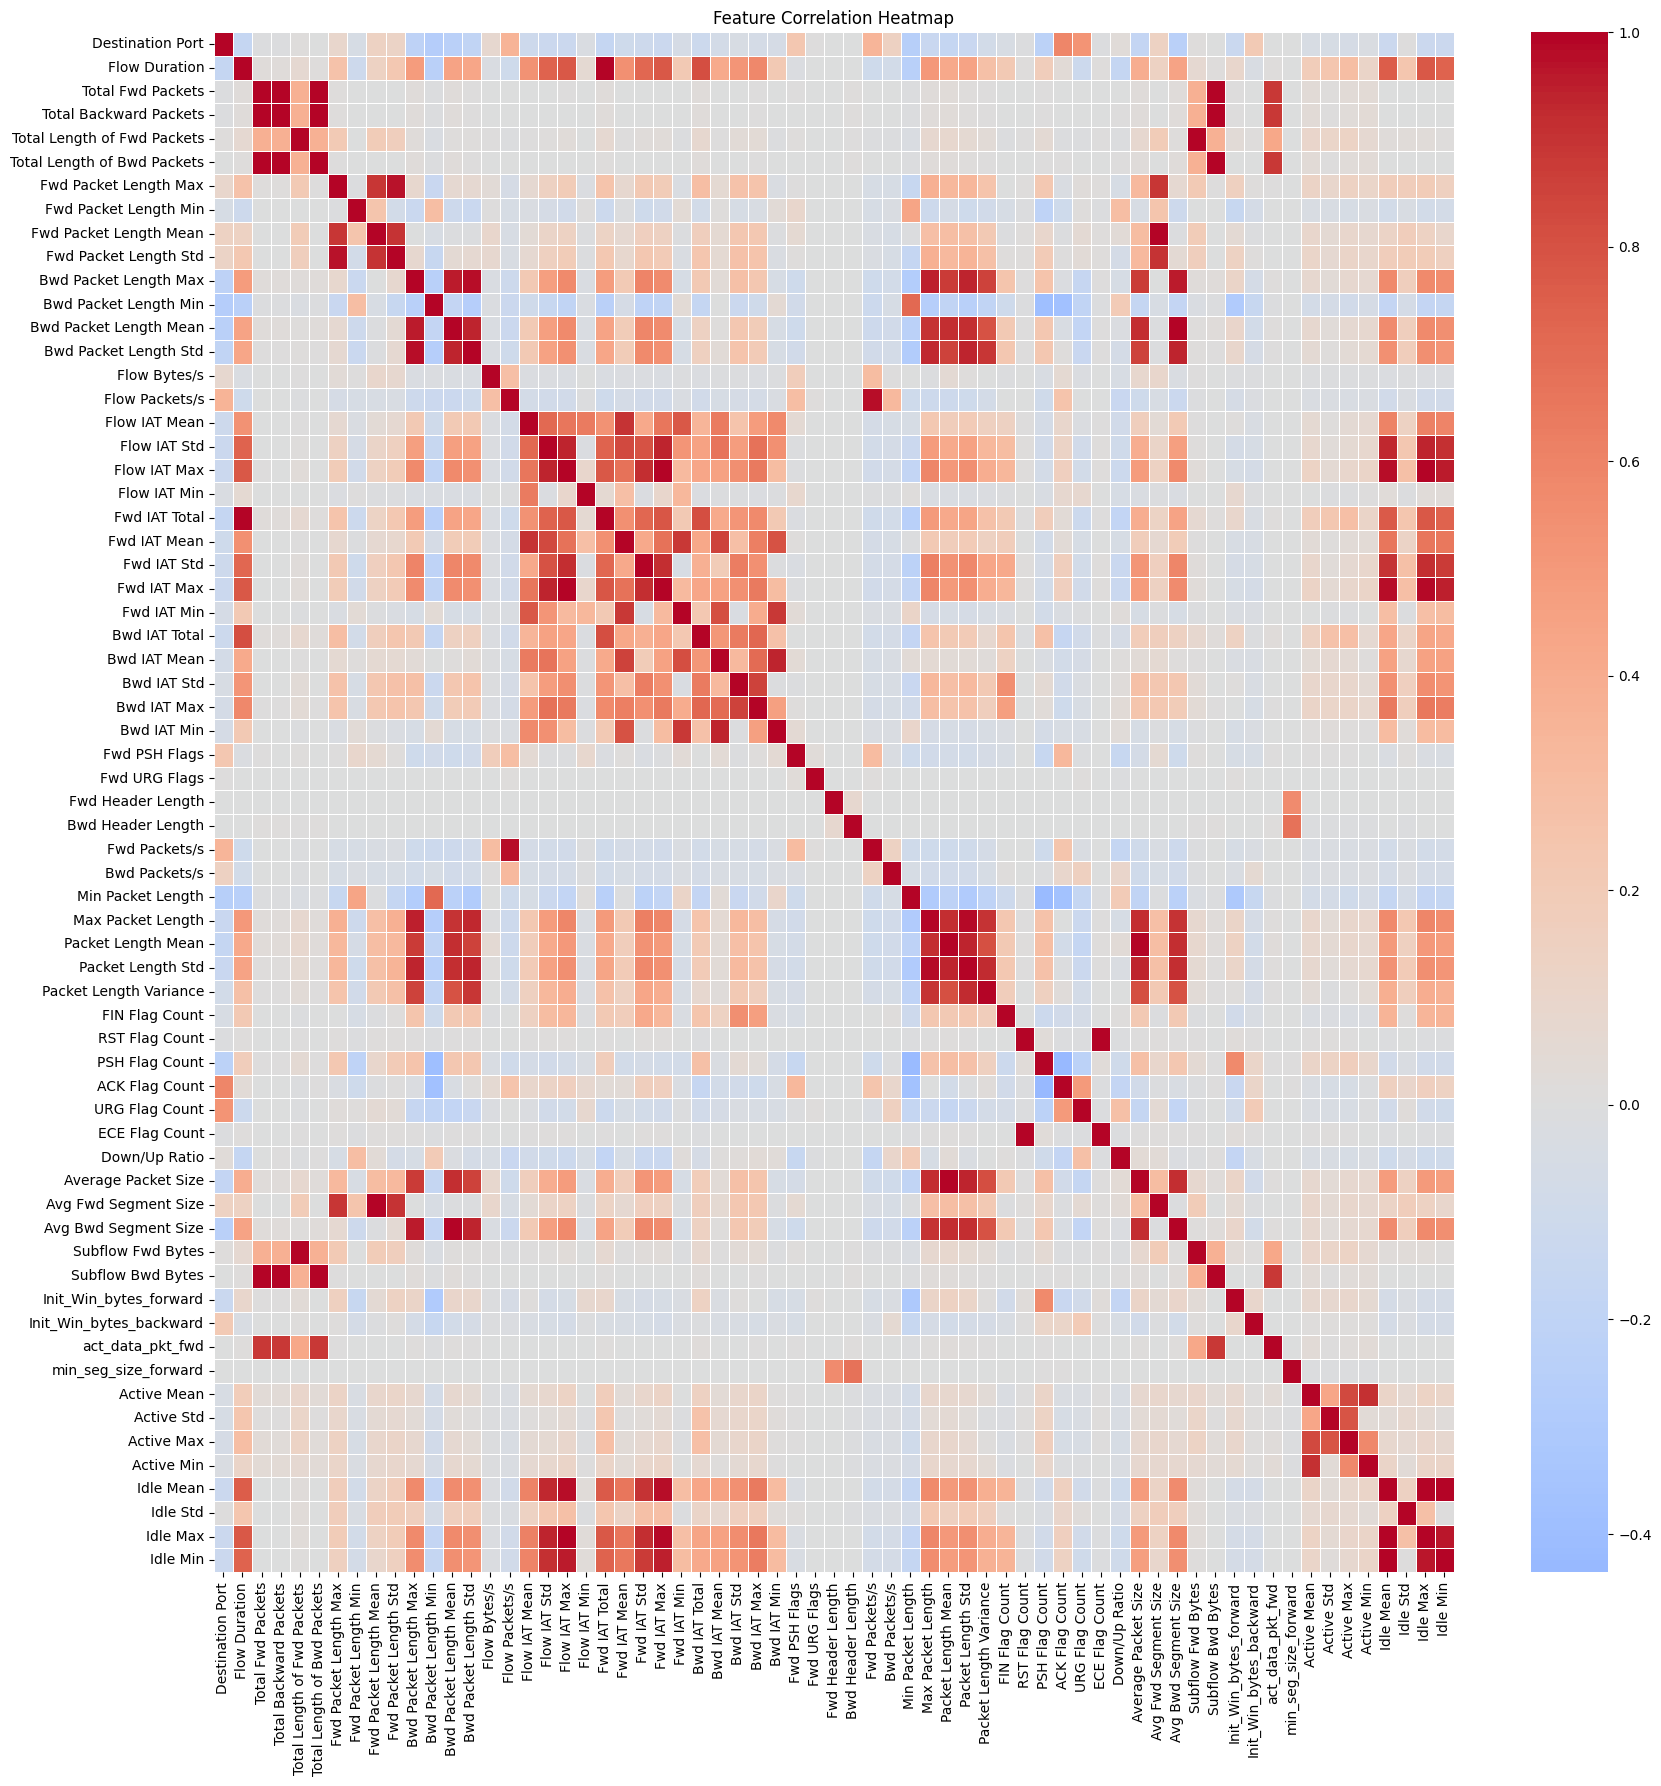

In [38]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [39]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

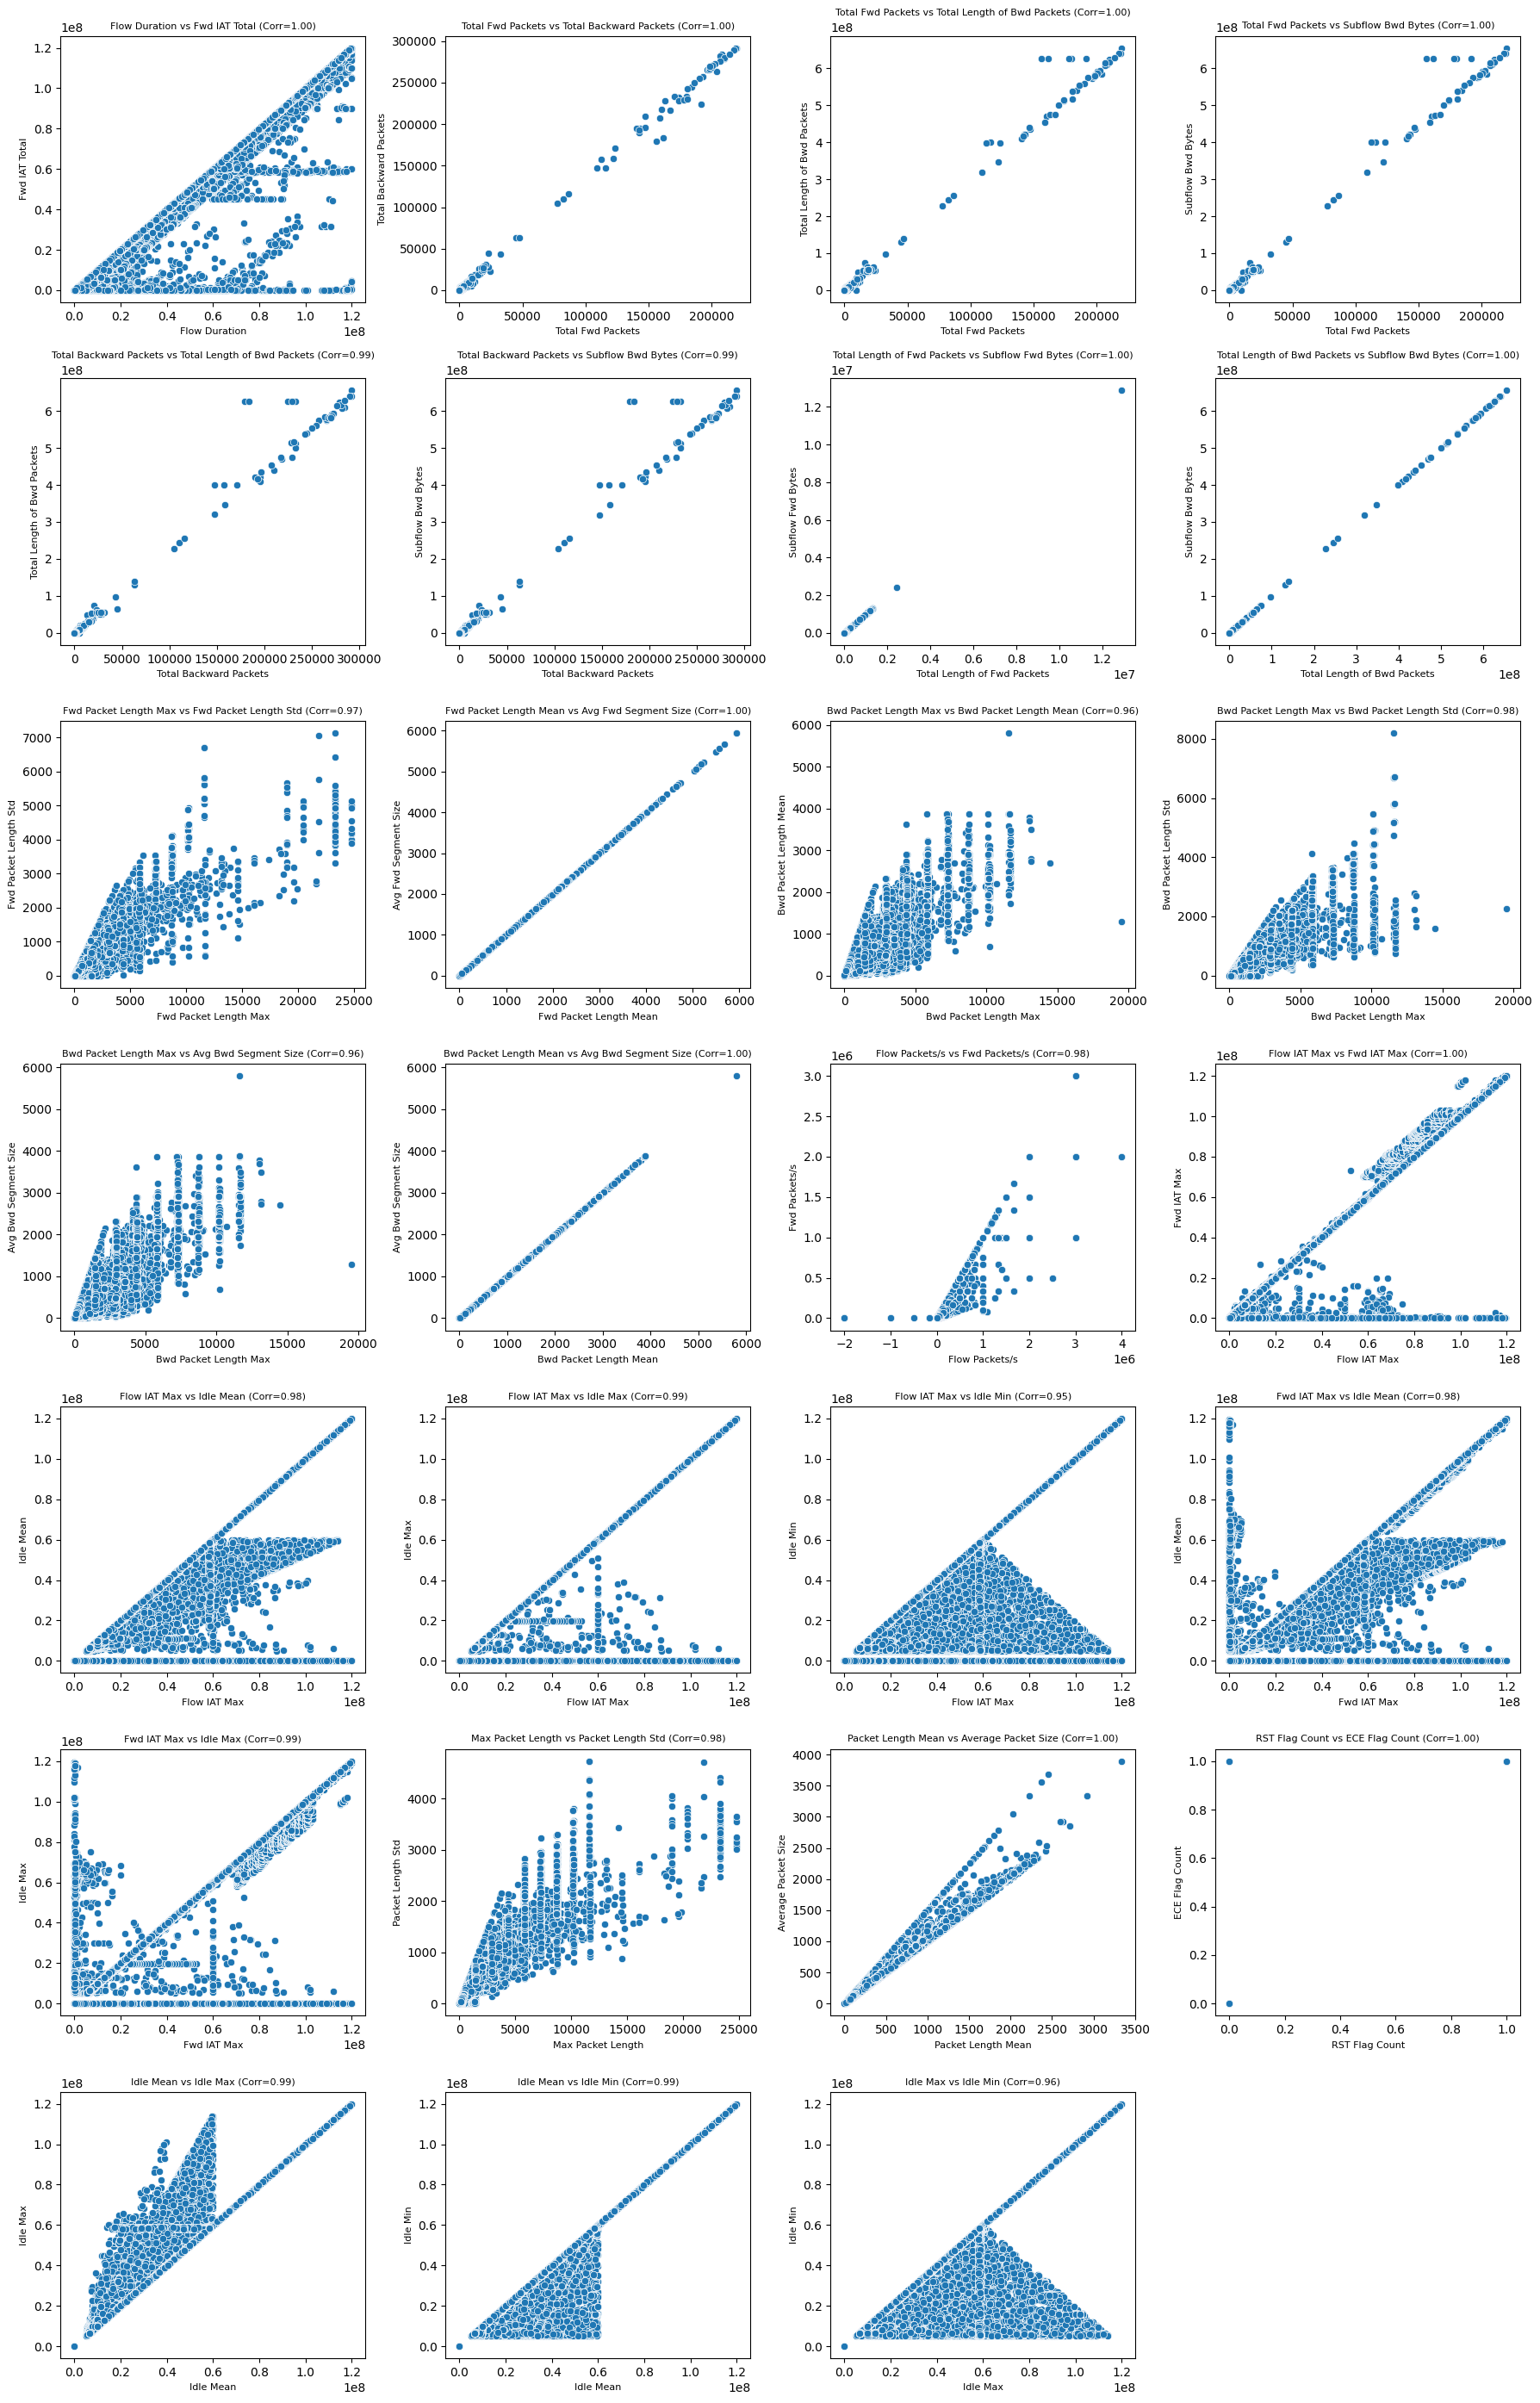

In [40]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [40]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [41]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

<Figure size 1500x1000 with 0 Axes>

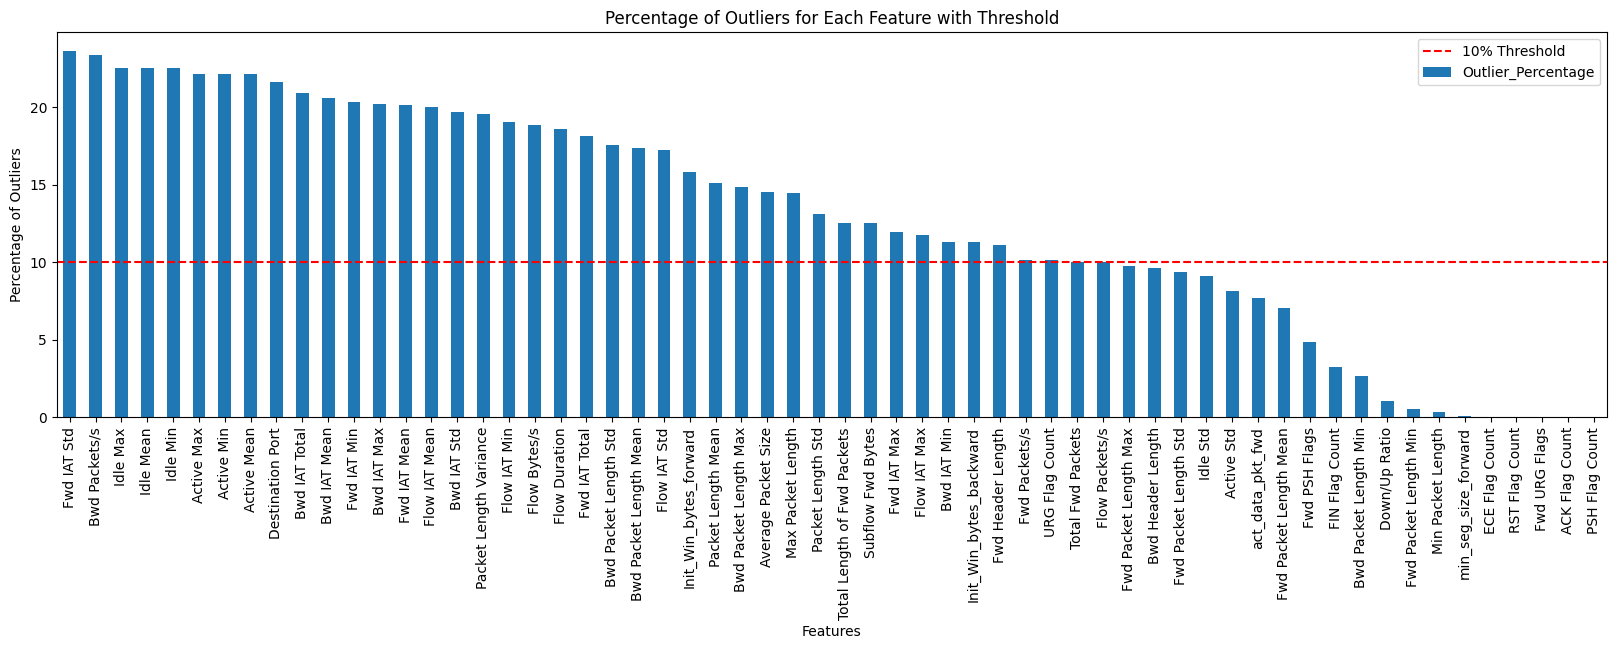

In [43]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [44]:
# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))

# Cleaning up
del outliers_df

Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Std                           23.657989
Bwd Packets/s                         23.402391
Idle Mean                             22.501508
Idle Min                              22.501508
Idle Max                              22.501508
Active Max                            22.167917
Active Mean                           22.167917
Active Min                            22.167917
Destination Port                      21.645137
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20.602908
Fwd IAT Min                           20.366311
Bwd IAT Max                           20.187555
Fwd IAT Mean                          20.126462
Flow IAT Mean                         19.985512
Bwd IAT Std                           19.700319
Packet Length Variance                19.538899
Flow IAT Min                          19.072649
Flow Bytes/s                          18.84

In [ ]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


In [46]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


In [47]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PERSIAPAN DATA ---
# Asumsi: 'data' adalah DataFrame awal Anda yang berisi semua fitur + 'Attack Type'
# Kita ambil sampel dulu biar cepat (statistik Levene/Kruskal lambat di 2.5 juta baris)
SAMPLE_SIZE = 100000 
if len(data) > SAMPLE_SIZE:
    data_sample = data.sample(n=SAMPLE_SIZE, random_state=42)
else:
    data_sample = data.copy()

# Pisahkan Fitur Numerik dan Target
# Pastikan target diubah jadi biner (0=Normal, 1=Attack) untuk keperluan seleksi ini
y_sample = data_sample['Attack Type'].apply(lambda x: 0 if 'NORMAL' in x.upper() else 1)
X_sample = data_sample.select_dtypes(include=[np.number])

# Simpan nama fitur awal
initial_features = X_sample.columns.tolist()
current_features = initial_features.copy()

print(f"🔹 Fitur Awal: {len(current_features)}")

🔹 Fitur Awal: 60



--- TAHAP 1: LEVENE FILTERING ---
❌ Dibuang Levene : 7 fitur
✅ Lolos Levene   : 53 fitur

📋 DAFTAR FITUR YANG DIBUANG (LEVENE):
['Total Length of Fwd Packets', 'Bwd IAT Total', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Subflow Fwd Bytes', 'min_seg_size_forward']


C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_1976\2472420325.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_levene, x='Feature', y='P-Value', palette=colors.tolist())


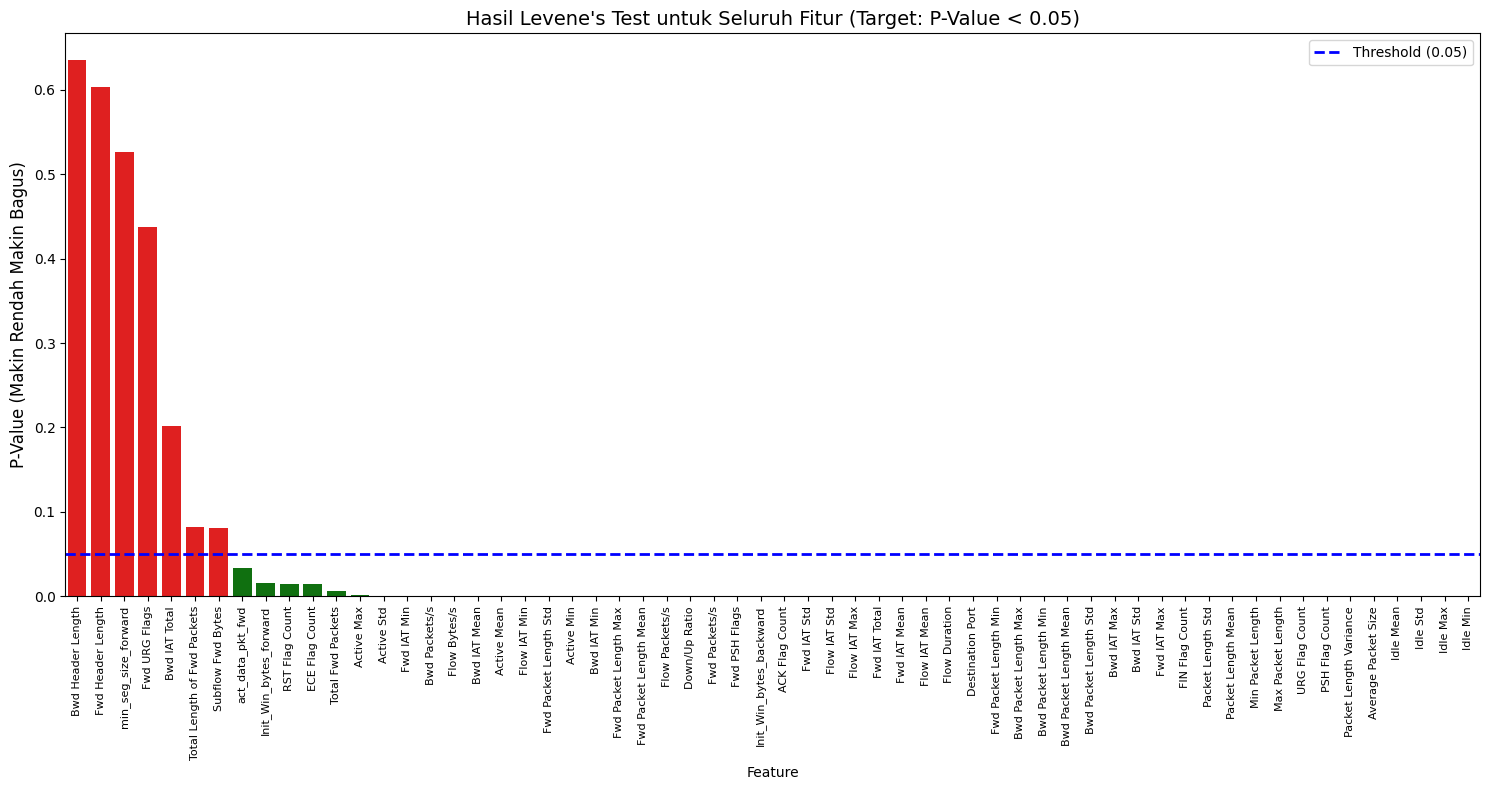

In [48]:
# ==============================================================================
# TAHAP 1: LEVENE'S TEST (Dengan Visualisasi & List)
# ==============================================================================
print("\n--- TAHAP 1: LEVENE FILTERING ---")

levene_results = []
levene_keep = []
levene_drop = []

for col in current_features:
    group_normal = X_sample[y_sample == 0][col]
    group_attack = X_sample[y_sample == 1][col]
    
    # 1. Cek Variansi 0 (Konstan)
    if group_normal.var() == 0 and group_attack.var() == 0:
        levene_drop.append(col)
        levene_results.append({'Feature': col, 'P-Value': 1.0, 'Status': 'Drop (Konstan)'})
        continue

    try:
        # 2. Hitung Levene Test
        stat, p = stats.levene(group_normal, group_attack)
        
        # 3. Evaluasi
        if p < 0.05: # Signifikan (Variansi BEDA -> BAGUS)
            levene_keep.append(col)
            status = 'Keep'
        else: # Tidak Signifikan (Variansi SAMA -> JELEK)
            levene_drop.append(col)
            status = 'Drop'
            
        levene_results.append({'Feature': col, 'P-Value': p, 'Status': status})
        
    except Exception as e:
        levene_drop.append(col)
        levene_results.append({'Feature': col, 'P-Value': 1.0, 'Status': 'Drop (Error)'})

# Buat DataFrame Hasil
df_levene = pd.DataFrame(levene_results)

# --- A. OUTPUT TEKS ---
print(f"❌ Dibuang Levene : {len(levene_drop)} fitur")
print(f"✅ Lolos Levene   : {len(levene_keep)} fitur")

print("\n📋 DAFTAR FITUR YANG DIBUANG (LEVENE):")
if len(levene_drop) > 0:
    print(levene_drop)
else:
    print("- Tidak ada fitur yang dibuang (Semua lolos) -")

# --- B. VISUALISASI SELURUH FITUR ---
plt.figure(figsize=(15, 8))

# Kita urutkan berdasarkan P-Value agar terlihat rapi
df_levene = df_levene.sort_values(by='P-Value', ascending=False)

# Plot Bar Chart
# Warna: Merah jika Drop, Hijau jika Keep
colors = df_levene['Status'].apply(lambda x: 'red' if 'Drop' in x else 'green')
barplot = sns.barplot(data=df_levene, x='Feature', y='P-Value', palette=colors.tolist())

# Garis Threshold 0.05
plt.axhline(0.05, color='blue', linestyle='--', linewidth=2, label='Threshold (0.05)')

# Dekorasi
plt.xticks(rotation=90, fontsize=8) # Putar label agar terbaca
plt.title("Hasil Levene's Test untuk Seluruh Fitur (Target: P-Value < 0.05)", fontsize=14)
plt.ylabel("P-Value (Makin Rendah Makin Bagus)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# --- C. UPDATE FITUR ---
current_features = levene_keep


--- TAHAP 2: KRUSKAL-WALLIS FILTERING ---
❌ Dibuang Kruskal: 0 fitur
✅ Lolos Kruskal  : 53 fitur

📋 DAFTAR FITUR YANG DIBUANG (KRUSKAL):
- Tidak ada fitur yang dibuang (Semua lolos) -


C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_1976\484492107.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_kruskal, x='Feature', y='P-Value', palette=colors.tolist())


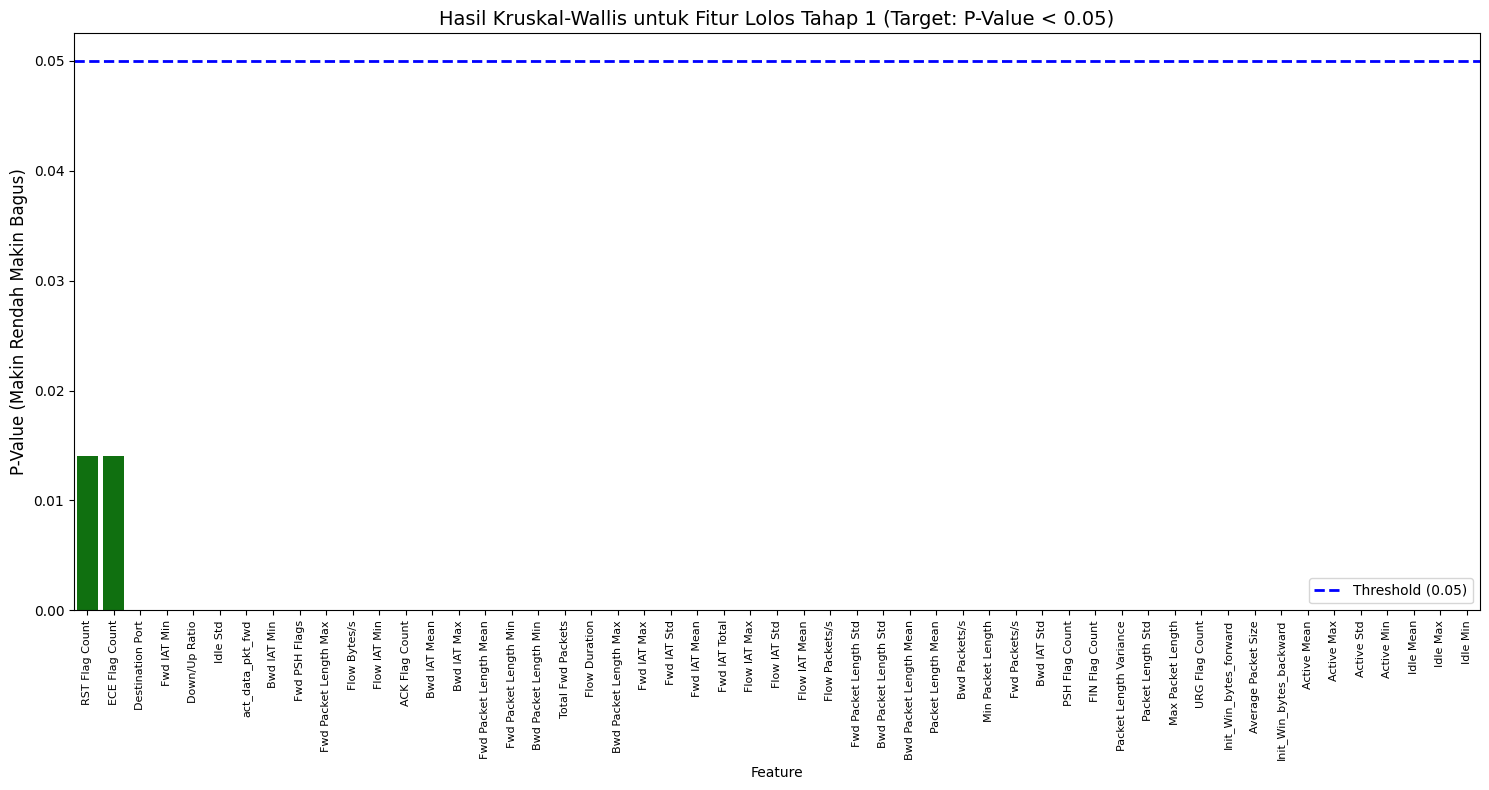


🔹 Sisa Fitur untuk Tahap 3 (LightGBM): 53


In [49]:
# ==============================================================================
# TAHAP 2: KRUSKAL-WALLIS TEST (Dengan Visualisasi & List)
# ==============================================================================
# Hipotesis: 
# H0: Distribusi data Normal dan Attack SAMA (Fitur jelek) -> P-Value Besar
# H1: Distribusi data Normal dan Attack BEDA (Fitur bagus) -> P-Value Kecil (< 0.05)

print("\n--- TAHAP 2: KRUSKAL-WALLIS FILTERING ---")

kruskal_results = []
kruskal_keep = []
kruskal_drop = []

for col in current_features:
    group_normal = X_sample[y_sample == 0][col]
    group_attack = X_sample[y_sample == 1][col]
    
    try:
        # Hitung Kruskal-Wallis H-test
        stat, p = stats.kruskal(group_normal, group_attack)
        
        # Evaluasi P-Value
        if p < 0.05: # Signifikan (Distribusi BEDA -> BAGUS)
            kruskal_keep.append(col)
            status = 'Keep'
        else: # Tidak Signifikan (Distribusi MIRIP -> JELEK)
            kruskal_drop.append(col)
            status = 'Drop'
            
        kruskal_results.append({'Feature': col, 'P-Value': p, 'Status': status})
            
    except Exception as e:
        # Jika ada error (misal data kosong), masukkan ke drop
        kruskal_drop.append(col)
        kruskal_results.append({'Feature': col, 'P-Value': 1.0, 'Status': 'Drop (Error)'})

# Buat DataFrame Hasil
df_kruskal = pd.DataFrame(kruskal_results)

# --- A. OUTPUT TEKS ---
print(f"❌ Dibuang Kruskal: {len(kruskal_drop)} fitur")
print(f"✅ Lolos Kruskal  : {len(kruskal_keep)} fitur")

print("\n📋 DAFTAR FITUR YANG DIBUANG (KRUSKAL):")
if len(kruskal_drop) > 0:
    print(kruskal_drop)
else:
    print("- Tidak ada fitur yang dibuang (Semua lolos) -")

# --- B. VISUALISASI SELURUH FITUR ---
plt.figure(figsize=(15, 8))

# Urutkan berdasarkan P-Value (Yang jelek/tinggi di kiri, yang bagus/rendah di kanan)
# atau sebaliknya agar enak dilihat
df_kruskal = df_kruskal.sort_values(by='P-Value', ascending=False)

# Tentukan warna: Merah jika Drop, Hijau jika Keep
colors = df_kruskal['Status'].apply(lambda x: 'red' if 'Drop' in x else 'green')

# Plot Bar Chart
sns.barplot(data=df_kruskal, x='Feature', y='P-Value', palette=colors.tolist())

# Garis Threshold 0.05
plt.axhline(0.05, color='blue', linestyle='--', linewidth=2, label='Threshold (0.05)')

# Dekorasi
plt.xticks(rotation=90, fontsize=8) # Putar label agar terbaca
plt.title("Hasil Kruskal-Wallis untuk Fitur Lolos Tahap 1 (Target: P-Value < 0.05)", fontsize=14)
plt.ylabel("P-Value (Makin Rendah Makin Bagus)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# --- C. UPDATE FITUR ---
current_features = kruskal_keep
print(f"\n🔹 Sisa Fitur untuk Tahap 3 (LightGBM): {len(current_features)}")


--- TAHAP 3: LIGHTGBM RANKING & SELECTION ---
Dasar Ilmiah Pemotongan: Mengambil fitur yang menyumbang 99.0% total importance.
🔥 FINAL SELECTED FEATURES : 43
❌ DROPPED FEATURES       : 10

📋 DAFTAR FITUR YANG DIBUANG (LIGHTGBM - KONTRIBUSI RENDAH):
['Idle Min', 'Fwd PSH Flags', 'FIN Flag Count', 'Fwd Packet Length Min', 'Active Max', 'Active Mean', 'Packet Length Variance', 'RST Flag Count', 'ECE Flag Count', 'Idle Std']

Contoh Importance Fitur yang Dibuang:
                  Feature  Importance  Cumulative_Imp
43               Idle Min           8        0.993333
44          Fwd PSH Flags           6        0.995333
45         FIN Flag Count           5        0.997000
46  Fwd Packet Length Min           3        0.998000
47             Active Max           3        0.999000


C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_1976\4145386940.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=8)


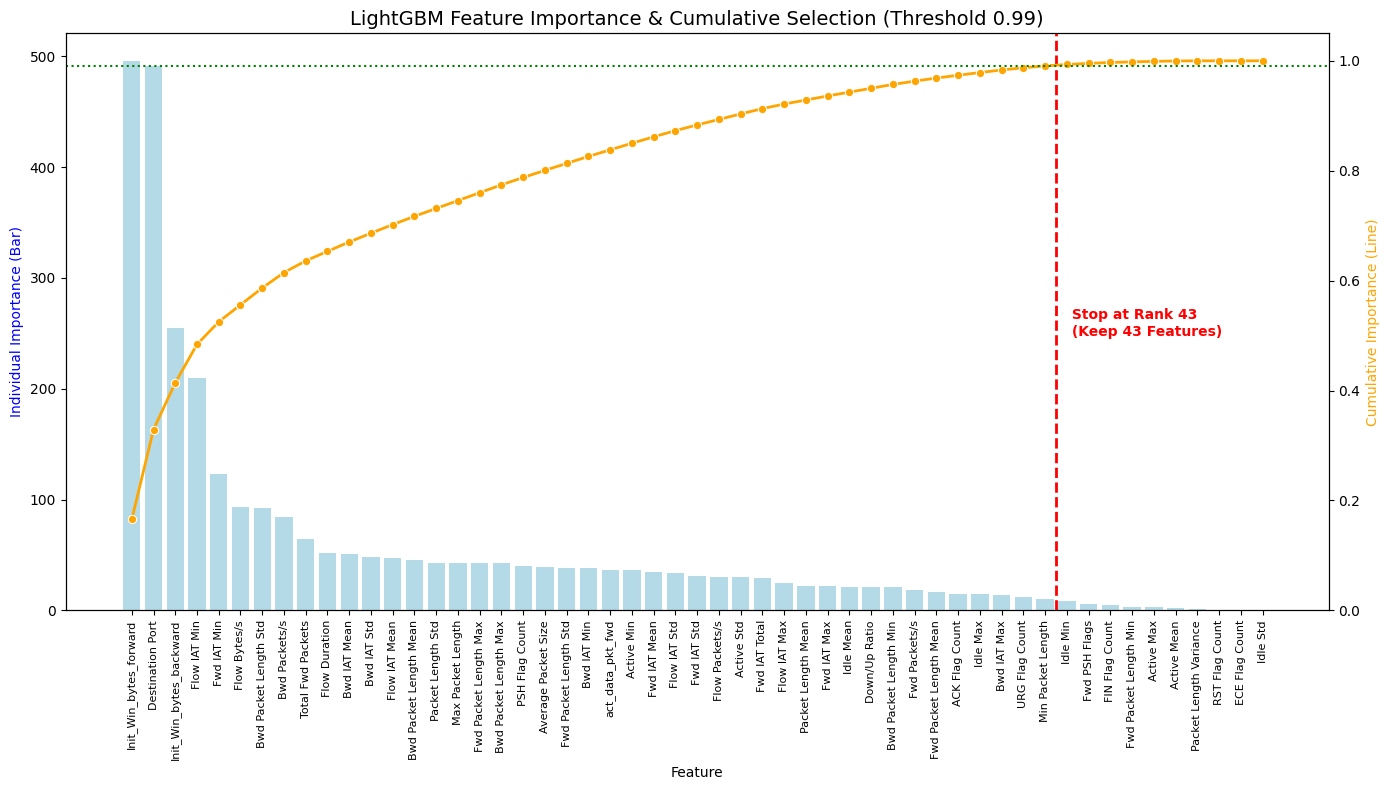


✅ Dataset Final Siap! ('data_selected')
Dimensi Akhir: (2520751, 44)


In [61]:
# ==============================================================================
# TAHAP 3: LIGHTGBM IMPORTANCE (Scientific Cut-off)
# ==============================================================================
print("\n--- TAHAP 3: LIGHTGBM RANKING & SELECTION ---")

# 1. Train LightGBM pada fitur yang lolos tahap sebelumnya
X_final_selection = X_sample[current_features]

# Kita gunakan n_estimators=100 sudah cukup stabil untuk feature importance
lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lgbm.fit(X_final_selection, y_sample)

# 2. Hitung Feature Importance
importance_df = pd.DataFrame({
    'Feature': current_features,
    'Importance': lgbm.feature_importances_
})

# Urutkan dari yang paling berkontribusi
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 3. Hitung Cumulative Importance (Dasar Matematis Pemotongan)
# Total Importance = 100%
total_importance = importance_df['Importance'].sum()
importance_df['Normalized_Imp'] = importance_df['Importance'] / total_importance
importance_df['Cumulative_Imp'] = importance_df['Normalized_Imp'].cumsum()

# 4. Tentukan Titik Potong (Threshold)
# Kita ingin mempertahankan fitur yang menyumbang 99% informasi.
# Sisa 1% di ekor dianggap noise/tidak signifikan.
THRESHOLD_CUMULATIVE = 0.99 

# Cari indeks di mana kumulatif pertama kali menembus 0.99
# Jika semua fitur penting, ambil semua.
try:
    cutoff_index = importance_df[importance_df['Cumulative_Imp'] >= THRESHOLD_CUMULATIVE].index[0]
    # Kita tambah 1 karena index mulai dari 0, dan kita mau fitur di titik itu juga masuk
    cutoff_count = cutoff_index + 1
except IndexError:
    cutoff_count = len(importance_df)

# --- A. OUTPUT TEKS ---
features_kept = importance_df.iloc[:cutoff_count]['Feature'].tolist()
features_dropped = importance_df.iloc[cutoff_count:]['Feature'].tolist()

print(f"Dasar Ilmiah Pemotongan: Mengambil fitur yang menyumbang {THRESHOLD_CUMULATIVE*100}% total importance.")
print(f"🔥 FINAL SELECTED FEATURES : {len(features_kept)}")
print(f"❌ DROPPED FEATURES       : {len(features_dropped)}")

print("\n📋 DAFTAR FITUR YANG DIBUANG (LIGHTGBM - KONTRIBUSI RENDAH):")
if len(features_dropped) > 0:
    print(features_dropped)
    # Tampilkan juga kontribusi mereka (pasti sangat kecil/nol)
    print("\nContoh Importance Fitur yang Dibuang:")
    print(importance_df.iloc[cutoff_count:].head()[['Feature', 'Importance', 'Cumulative_Imp']])
else:
    print("- Tidak ada fitur yang dibuang (Semua fitur penting) -")

# --- B. VISUALISASI PARETO (Dual Axis) ---
plt.figure(figsize=(14, 8))
ax1 = plt.gca()

# Plot Bar (Individual Importance)
# Ambil Top 50 saja biar grafik terbaca, tapi logic pemotongan tetap pakai seluruh data
plot_limit = min(60, len(importance_df))
sns.barplot(data=importance_df.head(plot_limit), x='Feature', y='Importance', 
            color='skyblue', alpha=0.7, ax=ax1)

# Plot Garis (Cumulative Importance)
ax2 = ax1.twinx()
sns.lineplot(data=importance_df.head(plot_limit), x='Feature', y='Cumulative_Imp', 
             color='orange', linewidth=2, marker='o', ax=ax2)

# Garis Batas Cut-off
# Menunjukkan di mana kita berhenti mengambil fitur
if cutoff_count < plot_limit:
    ax1.axvline(cutoff_count - 0.5, color='red', linestyle='--', linewidth=2, label=f'Cut-off ({THRESHOLD_CUMULATIVE*100}%)')
    ax1.text(cutoff_count, importance_df['Importance'].max()/2, 
             f' Stop at Rank {cutoff_count}\n (Keep {len(features_kept)} Features)', 
             color='red', fontweight='bold')

# Dekorasi
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=8)
ax1.set_ylabel('Individual Importance (Bar)', color='blue')
ax2.set_ylabel('Cumulative Importance (Line)', color='orange')
ax2.set_ylim(0, 1.05) # Skala 0 sampai 100%
ax2.axhline(THRESHOLD_CUMULATIVE, color='green', linestyle=':', label=f'Threshold {THRESHOLD_CUMULATIVE}')

plt.title(f'LightGBM Feature Importance & Cumulative Selection (Threshold {THRESHOLD_CUMULATIVE})', fontsize=14)
plt.tight_layout()
plt.show()

# --- C. UPDATE FINAL FEATURES ---
final_selected_features = features_kept

# --- D. SAVE DATASET AKHIR ---
# Terapkan ke dataset utama dan sertakan label
cols_to_keep = final_selected_features + ['Attack Type']
data_selected = data[cols_to_keep].copy()

print("\n✅ Dataset Final Siap! ('data_selected')")
print(f"Dimensi Akhir: {data_selected.shape}")

In [68]:
# ==============================================================================
# OUTPUT LENGKAP: SEMUA FITUR YANG DIBUANG OLEH LIGHTGBM
# ==============================================================================

print("\n📋 DETAIL SELURUH FITUR YANG DIBUANG (LIGHTGBM):")

# Ambil seluruh fitur di bawah cut-off
dropped_df = importance_df.iloc[cutoff_count:][
    ['Feature', 'Importance', 'Normalized_Imp', 'Cumulative_Imp']
].reset_index(drop=True)

# Cek apakah ada fitur yang dibuang
if dropped_df.shape[0] > 0:
    print(f"❌ Total fitur dibuang: {dropped_df.shape[0]}\n")
    print(dropped_df)
else:
    print("✅ Tidak ada fitur yang dibuang (semua fitur lolos cut-off)")



📋 DETAIL SELURUH FITUR YANG DIBUANG (LIGHTGBM):
❌ Total fitur dibuang: 10

                  Feature  Importance  Normalized_Imp  Cumulative_Imp
0                Idle Min           8        0.002667        0.993333
1           Fwd PSH Flags           6        0.002000        0.995333
2          FIN Flag Count           5        0.001667        0.997000
3   Fwd Packet Length Min           3        0.001000        0.998000
4              Active Max           3        0.001000        0.999000
5             Active Mean           2        0.000667        0.999667
6  Packet Length Variance           1        0.000333        1.000000
7          RST Flag Count           0        0.000000        1.000000
8          ECE Flag Count           0        0.000000        1.000000
9                Idle Std           0        0.000000        1.000000



--- TAHAP 3.1: EVALUASI PER JENIS SERANGAN (LABEL ASLI) ---
Kelas terdeteksi: 7 Jenis
List Kelas: ['Bots' 'Brute Force' 'DDoS' 'DoS' 'Normal Traffic' 'Port Scanning'
 'Web Attacks']

Melatih LightGBM Multi-class pada 43 fitur...

📝 Classification Report (Per Jenis Serangan):
                precision    recall  f1-score   support

          Bots       0.69      0.94      0.79       389
   Brute Force       1.00      1.00      1.00      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      0.99      0.99     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      1.00      0.99     18139
   Web Attacks       0.99      0.99      0.99       429

      accuracy                           1.00    504151
     macro avg       0.95      0.99      0.97    504151
  weighted avg       1.00      1.00      1.00    504151



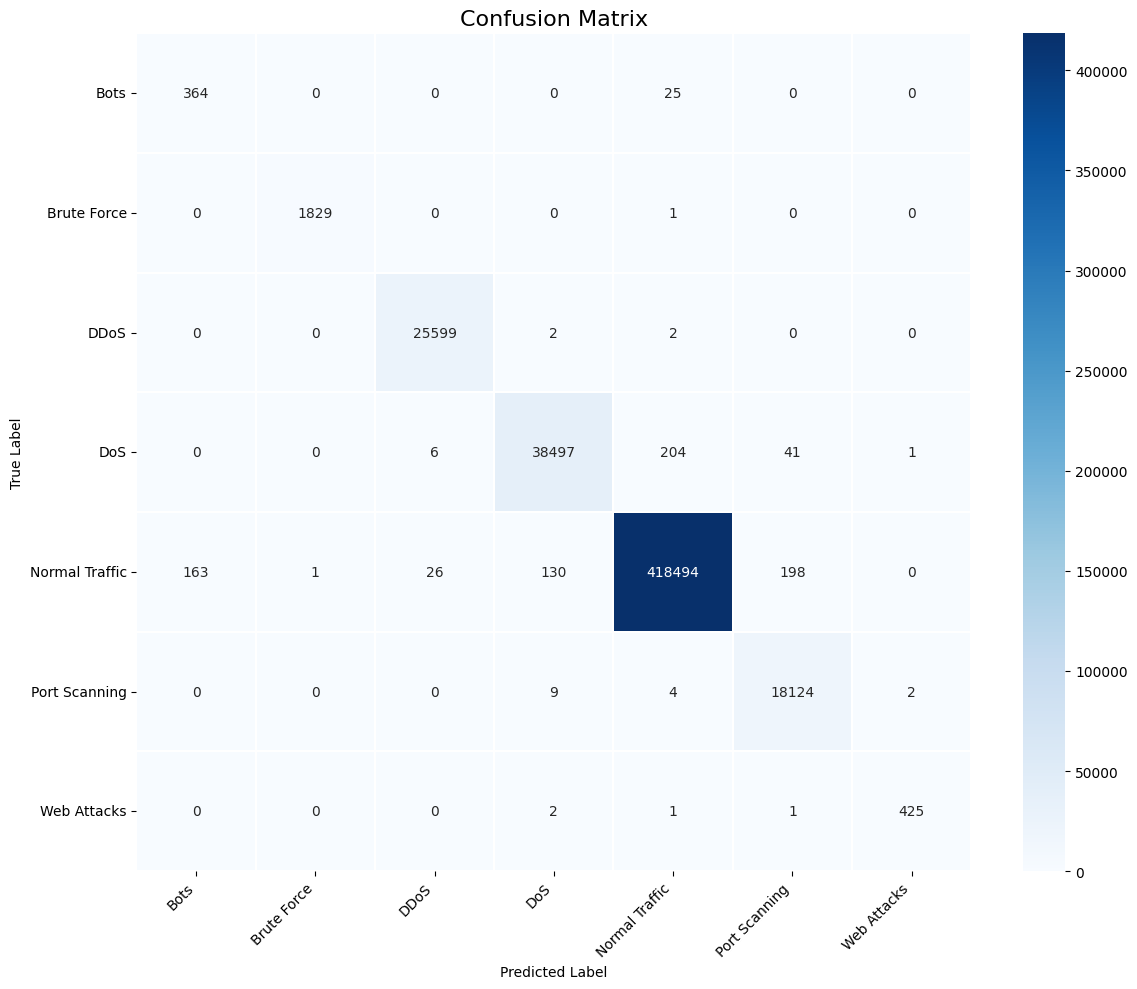

In [67]:
from sklearn.preprocessing import LabelEncoder

# ==============================================================================
# TAHAP 3.1: MULTI-CLASS EVALUATION (Cek Detail Serangan)
# ==============================================================================
print("\n--- TAHAP 3.1: EVALUASI PER JENIS SERANGAN (LABEL ASLI) ---")

# 1. Siapkan Data
# Kita gunakan label ASLI (Teks)
y_text = data_selected['Attack Type']
X_eval = data_selected.drop('Attack Type', axis=1)

# 2. Encode Label Teks ke Angka 0, 1, 2... (Hanya untuk Training Evaluasi ini)
le = LabelEncoder()
y_encoded = le.fit_transform(y_text)
label_names = le.classes_ # Simpan nama asli ('Bot', 'DDoS', 'Normal', dll)

print(f"Kelas terdeteksi: {len(label_names)} Jenis")
print(f"List Kelas: {label_names}")

# 3. Split Data (80% Train, 20% Test)
# Stratify agar setiap jenis serangan terwakili
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_eval, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nMelatih LightGBM Multi-class pada {X_train_eval.shape[1]} fitur...")

# 4. Train Model Evaluator (Multi-class Mode)
# Kita gunakan objective='multiclass'
evaluator = LGBMClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    objective='multiclass',
    num_class=len(label_names),
    class_weight='balanced' # Penting agar serangan kecil (Infiltration) 'dianggap'
)
evaluator.fit(X_train_eval, y_train_eval)

# 5. Prediksi
y_pred_eval = evaluator.predict(X_test_eval)

# 6. Tampilkan Classification Report (Dengan Nama Asli)
print("\n📝 Classification Report (Per Jenis Serangan):")
print(classification_report(y_test_eval, y_pred_eval, target_names=label_names))

# 7. Visualisasi Confusion Matrix (Multi-Class) - WARNA BIRU
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_eval, y_pred_eval)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',     # atau 'Blues_r' jika ingin lebih gelap
    cbar=True,        # aktifkan colorbar supaya seperti gambar
    xticklabels=label_names,
    yticklabels=label_names,
    linewidths=0.3,   # garis tipis seperti gambar kamu
    linecolor='white' # garis putih halus antar sel
)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Split to Binary

In [59]:
# ==============================================================================
# TAHAP 4: DATA SPLITTING DULU (Stratified by Original Label)
# ==============================================================================
print("\n--- TAHAP 4: SPLITTING DATA (Berdasarkan Label Asli) ---")

# 1. Pisahkan Fitur (X) dan Label Mentah (y_raw)
cols_features = list(data_selected.columns)
cols_features.remove('Attack Type')

X = data_selected[cols_features]
y_raw = data_selected['Attack Type'] # Masih berupa teks: 'Normal', 'DDoS', dll

# 2. Lakukan Split (70:15:15)
# Kita stratify berdasarkan y_raw agar setiap jenis serangan tersebar merata
print("Melakukan splitting...")

# Tahap 1: Ambil 70% Train, sisakan 30% Temp
X_train, X_temp, y_train_raw, y_temp_raw = train_test_split(
    X, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

# Tahap 2: Bagi sisa 30% menjadi Validasi (15%) dan Testing (15%)
X_val, X_test, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw
)

print(f"Training Data : {X_train.shape}")
print(f"Validation    : {X_val.shape}")
print(f"Testing Data  : {X_test.shape}")


--- TAHAP 4: SPLITTING DATA (Berdasarkan Label Asli) ---
Melakukan splitting...
Training Data : (1764525, 43)
Validation    : (378113, 43)
Testing Data  : (378113, 43)


In [60]:
# ==============================================================================
# TAHAP 5: ENCODING TARGET SETELAH SPLIT (BINARY)
# ==============================================================================
print("\n--- TAHAP 5: ENCODING TARGET (BINARY) ---")

# Fungsi untuk encoding (biar konsisten di ke-3 data)
def encode_target(y_series):
    # Logika: 0 jika ada kata 'NORMAL', 1 jika lainnya
    return y_series.apply(lambda x: 0 if 'NORMAL' in str(x).upper() else 1)

# Terapkan ke masing-masing bagian
y_train = encode_target(y_train_raw)
y_val   = encode_target(y_val_raw)
y_test  = encode_target(y_test_raw)

# Validasi Singkat pada Data Training
jumlah_0 = (y_train == 0).sum()
jumlah_1 = (y_train == 1).sum()

print(f"Stats Training -> Normal (0): {jumlah_0} | Serangan (1): {jumlah_1}")
print(f"Ratio Serangan di Training: {jumlah_1 / len(y_train) * 100:.2f}%")

if jumlah_0 == 0:
    raise ValueError("⚠️ FATAL ERROR: Data Normal hilang di Training Set! Cek string labelnya.")
else:
    print("✅ Encoding Berhasil. Struktur data aman.")


--- TAHAP 5: ENCODING TARGET (BINARY) ---
Stats Training -> Normal (0): 1466539 | Serangan (1): 297986
Ratio Serangan di Training: 16.89%
✅ Encoding Berhasil. Struktur data aman.


In [61]:
# ==============================================================================
# TAHAP 6: PENYIMPANAN AKHIR (SAVE TO JOBLIB)
# ==============================================================================
print("\n--- TAHAP 6: MENYIMPAN DATASET ---")

if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

# Bungkus semua variabel ke dalam satu Dictionary
dataset_pack = {
    'X_train': X_train,
    'y_train': y_train, # Sudah binary (0/1)
    'X_val':   X_val,
    'y_val':   y_val,   # Sudah binary (0/1)
    'X_test':  X_test,
    'y_test':  y_test,  # Sudah binary (0/1)
    'features': cols_features
}

# Simpan ke file .joblib
save_path = 'processed_data/split-binary.joblib'
joblib.dump(dataset_pack, save_path, compress=3)

print(f"SUKSES! Dataset tersimpan di:\n{save_path}")


--- TAHAP 6: MENYIMPAN DATASET ---
SUKSES! Dataset tersimpan di:
processed_data/split-binary.joblib


## Binary to Split

In [51]:
# ==============================================================================
# TAHAP 4: ENCODING TARGET (BINARY)
# ==============================================================================
print("\n--- TAHAP 4: ENCODING TARGET (BINARY) ---")

# 1. Cek Label Asli (Untuk memastikan tidak salah target)
print("Sampel Label Asli:", data_selected['Attack Type'].unique()[:5]) 

# 2. Konversi ke Angka (0 = Normal, 1 = Serangan)
# PENTING: Kita cari kata 'NORMAL', bukan 'BENIGN'
y_binary = data_selected['Attack Type'].apply(lambda x: 0 if 'NORMAL' in x.upper() else 1)

# 3. Pisahkan Fitur (X) dan Target (y)
cols_features = list(data_selected.columns)
cols_features.remove('Attack Type') # Buang label dari data X
X = data_selected[cols_features]

# 4. Validasi Hasil Encoding
jumlah_0 = (y_binary == 0).sum()
jumlah_1 = (y_binary == 1).sum()

print(f"Total Normal (0)   : {jumlah_0}")
print(f"Total Serangan (1) : {jumlah_1}")
print(f"Ratio Serangan     : {jumlah_1 / len(y_binary) * 100:.2f}%")

if jumlah_0 == 0:
    raise ValueError("⚠️ FATAL ERROR: Data Normal terdeteksi 0! Cek logika 'lambda' di atas.")
else:
    print("✅ Encoding Berhasil. Data Normal aman.")


--- TAHAP 4: ENCODING TARGET (BINARY) ---
Sampel Label Asli: ['Normal Traffic' 'DDoS' 'Port Scanning' 'Bots' 'Web Attacks']
Total Normal (0)   : 2095057
Total Serangan (1) : 425694
Ratio Serangan     : 16.89%
✅ Encoding Berhasil. Data Normal aman.


In [52]:
# ==============================================================================
# TAHAP 5: DATA SPLITTING (70:15:15)
# ==============================================================================
print("\n--- TAHAP 5: SPLITTING DATA (Stratified) ---")

# Tahap 1: Ambil 70% untuk Training, sisakan 30% (Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

# Tahap 2: Bagi sisa 30% menjadi Validasi (15%) dan Testing (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training Data : {X_train.shape} (Untuk Belajar)")
print(f"Validation    : {X_val.shape}   (Untuk Evaluasi Harian)")
print(f"Testing Data  : {X_test.shape}  (Untuk Ujian Akhir)")


--- TAHAP 5: SPLITTING DATA (Stratified) ---
Training Data : (1764525, 43) (Untuk Belajar)
Validation    : (378113, 43)   (Untuk Evaluasi Harian)
Testing Data  : (378113, 43)  (Untuk Ujian Akhir)


In [58]:
import joblib
import os
# (Pastikan variabel X_train, y_train, X_val, y_val, X_test, y_test, dan cols_features sudah ada di memory)

# ==============================================================================
# TAHAP 6: PENYIMPANAN AKHIR (SAVE TO JOBLIB)
# ==============================================================================
print("\n--- TAHAP 6: MENYIMPAN DATASET ---")

# Buat folder jika belum ada
if not os.path.exists('processed_data'):
    os.makedirs('processed_data')

# Bungkus semua variabel penting ke dalam satu Dictionary
dataset_pack = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val':   X_val,
    'y_val':   y_val,
    'X_test':  X_test,
    'y_test':  y_test,
    'features': cols_features # Simpan juga nama fiturnya agar tidak lupa
}

# Simpan ke file dengan ekstensi .joblib
save_path = 'processed_data/binary_dataset.joblib'
# compress=3 digunakan agar ukuran file tidak terlalu besar
joblib.dump(dataset_pack, save_path, compress=3) 

print(f"SUKSES! Dataset siap training tersimpan di:\n{save_path}")


--- TAHAP 6: MENYIMPAN DATASET ---
SUKSES! Dataset siap training tersimpan di:
processed_data/binary_dataset.joblib


# --------------


--- ANALISIS DISTRIBUSI DATA (BINARY STRATIFIED) ---
Melakukan splitting (Stratify by Binary)...

📊 TABEL DISTRIBUSI SERANGAN DI SETIAP BAGIAN:
                  Train     Val    Test    Total
Attack Type                                     
Normal Traffic  1466539  314259  314259  2095057
DoS              135572   29167   29006   193745
DDoS              89622   19046   19346   128014
Port Scanning     63473   13625   13596    90694
Brute Force        6474    1397    1279     9150
Web Attacks        1480     333     330     2143
Bots               1365     286     297     1948

✅ AMAN: Semua jenis serangan terwakili di Training set.


<Figure size 1200x600 with 0 Axes>

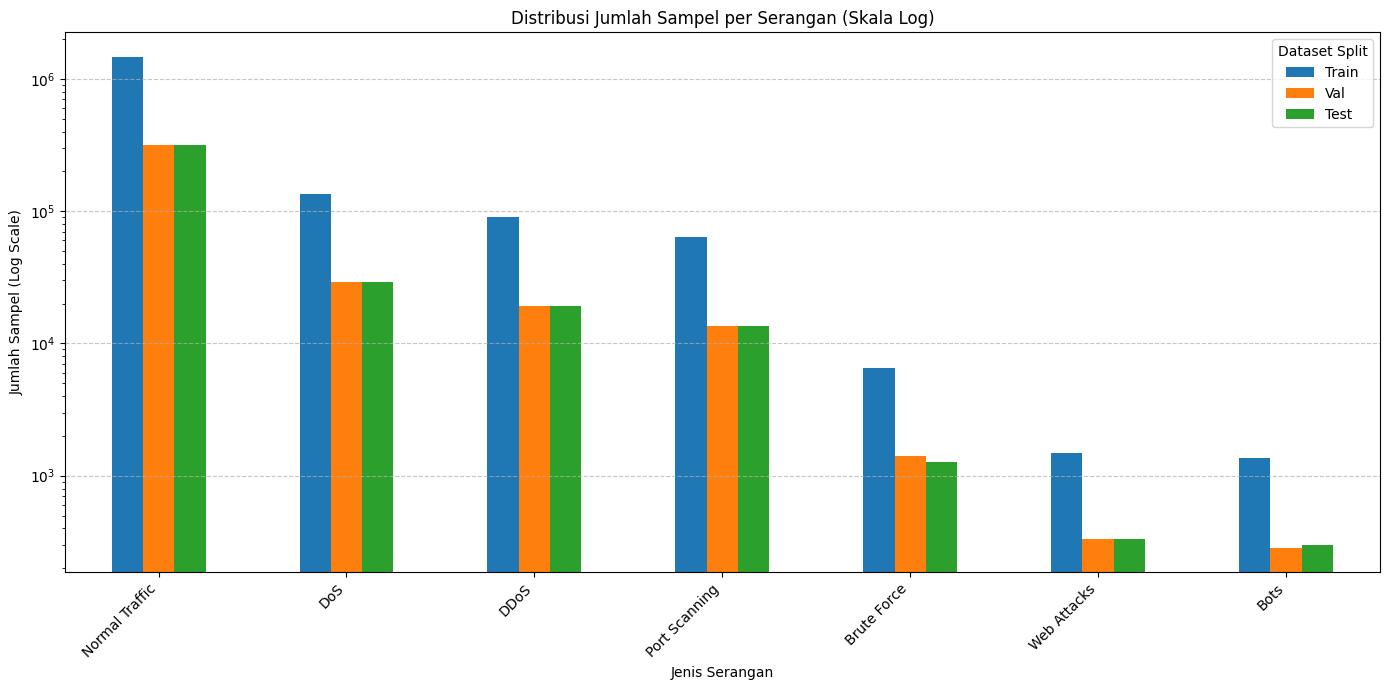

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ==========================================
# CEK DISTRIBUSI SETELAH BINARY SPLIT
# ==========================================

print("\n--- ANALISIS DISTRIBUSI DATA (BINARY STRATIFIED) ---")

# 1. Siapkan Data
# X = Fitur
# y_binary = Target 0/1 (Untuk Stratify)
# y_raw = Label Asli Teks (Hanya untuk dipantau, tidak dipakai training)

cols_features = list(data_selected.columns)
cols_features.remove('Attack Type')

X = data_selected[cols_features]
y_raw = data_selected['Attack Type'] # Label Asli (String)
y_binary = data_selected['Attack Type'].apply(lambda x: 0 if 'NORMAL' in str(x).upper() else 1)

# 2. Lakukan Split
# TRIK: Kita masukkan y_raw ke dalam train_test_split juga agar ikut terpotong rapi
print("Melakukan splitting (Stratify by Binary)...")

X_train, X_temp, y_bin_train, y_bin_temp, y_raw_train, y_raw_temp = train_test_split(
    X, y_binary, y_raw, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_bin_val, y_bin_test, y_raw_val, y_raw_test = train_test_split(
    X_temp, y_bin_temp, y_raw_temp, test_size=0.5, random_state=42, stratify=y_bin_temp
)

# 3. Hitung Persebaran di Setiap Bagian
def get_distribution(y_raw_series, name):
    dist = y_raw_series.value_counts().to_frame(name=name)
    return dist

dist_train = get_distribution(y_raw_train, 'Train')
dist_val   = get_distribution(y_raw_val, 'Val')
dist_test  = get_distribution(y_raw_test, 'Test')

# Gabungkan jadi satu tabel
comparison_df = pd.concat([dist_train, dist_val, dist_test], axis=1).fillna(0).astype(int)
comparison_df['Total'] = comparison_df.sum(axis=1)
comparison_df = comparison_df.sort_values(by='Total', ascending=False)

print("\n📊 TABEL DISTRIBUSI SERANGAN DI SETIAP BAGIAN:")
print(comparison_df)

# 4. Cek Serangan yang Hilang (Missing in Train)
# Ini bahaya: Kalau ada di Test tapi 0 di Train
missing_in_train = comparison_df[comparison_df['Train'] == 0]
if len(missing_in_train) > 0:
    print("\n⚠️ PERINGATAN: Serangan berikut TIDAK ADA di Training set (Blind Spot):")
    print(missing_in_train.index.tolist())
else:
    print("\n✅ AMAN: Semua jenis serangan terwakili di Training set.")

# 5. Visualisasi Grafik (Top 10 Serangan Terbanyak)
plt.figure(figsize=(12, 6))
top_10 = comparison_df.head(10).drop(columns=['Total'])
# Normalisasi agar grafik enak dilihat (karena jumlah Train jauh lebih banyak)
top_10_pct = top_10.div(top_10.sum(axis=0), axis=1) * 100 

top_10.plot(kind='bar', figsize=(14, 7), logy=True) # Pakai skala Logaritmik biar data kecil kelihatan
plt.title('Distribusi Jumlah Sampel per Serangan (Skala Log)')
plt.ylabel('Jumlah Sampel (Log Scale)')
plt.xlabel('Jenis Serangan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()